# Testing RCA algortithms 

In [39]:
import pandas as pd
from pyrca.analyzers.ht import HT
from pyrca.analyzers.random_walk import RandomWalk
from pyrca.outliers.stats import StatsDetector, StatsDetectorConfig
from pyrca.analyzers.bayesian import BayesianNetwork
from pyrca.analyzers.epsilon_diagnosis import EpsilonDiagnosis
from pyrca.analyzers.rcd import RCD
import networkx as nx

## Data

In [40]:
BASE_DIR = "../data/"

graph_df_m = pd.read_csv(BASE_DIR + 'Incidence_Matrix_of_the_Graph.csv', index_col=0)
graph_df = pd.read_csv(BASE_DIR + 'Causal_Graph_Incidence_Matrix.csv', index_col=0)

In [41]:
df_m = pd.read_csv(BASE_DIR + 'rca_microservice_architecture_latencies.csv')
df = pd.read_csv(BASE_DIR + '2021 Data.csv')
df['Shopping Event?'] = df['Shopping Event?'].astype(int)
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = (df['Date'] - df['Date'].min()).dt.total_seconds()
column_to_move = 'Time'
cols = [column_to_move] + [col for col in df if col != column_to_move]
df = df[cols]
df = df.drop(columns=['Date'])

df.head()

,Time,Shopping Event?,Ad Spend,Page Views,Unit Price,Sold Units,Revenue,Operational Cost,Profit
0,0.0,0,1490.490265,11861,999.0,2317,2314683.0,1.660000e+06,654683.105645
1,86400.0,0,1455.917463,11776,999.0,2355,2352645.0,1.678959e+06,673685.919907
2,172800.0,0,1405.824790,11861,999.0,2391,2388609.0,1.696906e+06,691702.862976
3,259200.0,0,1379.299391,11677,999.0,2344,2341656.0,1.673381e+06,668275.364656
4,345600.0,0,1234.199268,11871,999.0,2412,2409588.0,1.707253e+06,702335.386013


In [42]:
abnormal_df = pd.read_csv(BASE_DIR + '2022 First Day.csv')
abnormal_df['Shopping Event?'] = abnormal_df['Shopping Event?'].astype(int)
abnormal_df['Date'] = pd.to_datetime(abnormal_df['Date']) 
abnormal_df['Time'] = (abnormal_df['Date'] - abnormal_df['Date'].min()).dt.total_seconds()
abnormal_df = abnormal_df[cols]
abnormal_df = abnormal_df.drop(columns=['Date'])
abnormal_df.head()

,Time,Shopping Event?,Ad Spend,Page Views,Unit Price,Sold Units,Revenue,Operational Cost,Profit
0,0.0,0,1392.335828,10018,899.1,2756,2477919.6,1.879401e+06,598518.397586


In [ ]:
abnormal_distribution_df_m = pd.read_csv(BASE_DIR + 'rca_microservice_architecture_anomaly_1000.csv')
abnormal_distribution_df = pd.read_csv(BASE_DIR + '2022 First Quarter.csv')
abnormal_distribution_df['Shopping Event?'] = abnormal_distribution_df['Shopping Event?'].astype(int)
abnormal_distribution_df['Date'] = pd.to_datetime(abnormal_distribution_df['Date']) 
abnormal_distribution_df['Time'] = (abnormal_distribution_df['Date'] - abnormal_distribution_df['Date'].min()).dt.total_seconds()
abnormal_distribution_df = abnormal_distribution_df[cols]
abnormal_distribution_df = abnormal_distribution_df.drop(columns=['Date'])

abnormal_distribution_df.head()

,Time,Shopping Event?,Ad Spend,Page Views,Unit Price,Sold Units,Revenue,Operational Cost,Profit
0,0.0,0,1392.335828,10018,899.1,2756,2477919.6,1.879401e+06,598518.397586
1,86400.0,0,1391.391381,10038,899.1,2726,2450946.6,1.864400e+06,586546.689520
2,172800.0,0,1293.990843,9941,899.1,2656,2388009.6,1.829299e+06,558710.202947
3,259200.0,0,1212.590398,9950,899.1,2741,2464433.1,1.871716e+06,592716.997018
4,345600.0,0,1182.469837,9764,899.1,2697,2424872.7,1.849701e+06,575171.638105


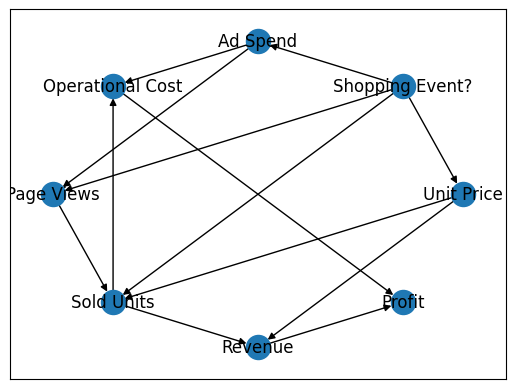

In [44]:
causal_graph = nx.DiGraph([('Page Views', 'Sold Units'),
                           ('Revenue', 'Profit'),
                           ('Unit Price', 'Sold Units'),
                           ('Unit Price', 'Revenue'),
                           ('Shopping Event?', 'Page Views'),
                           ('Shopping Event?', 'Sold Units'),
                           ('Shopping Event?', 'Unit Price'),
                           ('Shopping Event?', 'Ad Spend'),
                           ('Ad Spend', 'Page Views'),
                           ('Ad Spend', 'Operational Cost'),
                           ('Sold Units', 'Revenue'),
                           ('Sold Units', 'Operational Cost'),
                           ('Operational Cost', 'Profit')])

nx.draw_networkx(causal_graph, pos=nx.shell_layout(causal_graph))

## PyRCA

### Hypothesis-Testing Algorithm

The key idea of this approach is to map anomalies to unexpected interventions. Specifically, it assumes that the normal data come from the observational distribution, while the abnormal data come from an intervention that has disrupted the system. The goal of root cause scoring using hypothesis testing is to recognize the intervention by identifying the variables (nodes) that have been intervened upon, given the normal and abnormal data. This can be achieved using statistical tests to compare the observed variable distribution in abnormal data with the estimated variable distribution obtained by training the estimated model with the normal data. If the difference is statistically significant, the corresponding variable (node) is a potential root cause.

https://arxiv.org/pdf/2206.05871

In [45]:
model_ht = HT(config=HT.config_class(graph=graph_df))
model_ht.train(df)

In [46]:
model_ht.find_root_causes(abnormal_df)

RCAResults(root_cause_nodes=[('Revenue', 54.036222993373066), ('Unit Price', 8.64523685751185), ('Page Views', 6.630064268402317)], root_cause_paths={})

In [47]:
df_filtered = abnormal_distribution_df.drop(columns=['Time'])
model_ht.find_root_causes(df_filtered)

RCAResults(root_cause_nodes=[('Revenue', 62.32535704549109), ('Unit Price', 10.607057404901681), ('Page Views', 9.78494272651732)], root_cause_paths={})

### Random Walk

A random walk is a stochastic process that moves randomly from one node to another in a graph. It is guided by a transition probability matrix that specifies the likelihood of moving from one node to another. In the context of RCA, the random walk algorithm is based on the assumption that a metric that is highly correlated with the anomaly metrics is more likely to be the root cause. By conducting random walks on the graph, the RCA model can calculate root cause scores for each metric and identify the top-K metrics that are most likely to be the candidate root cause of the anomaly metrics. The transition probability matrix is a crucial component of random walk approaches for RCA. It determines the likelihood of moving from one node to another during a random walk. Typically, there are three steps involved in computing the transition probability matrix (Cheng et al., 2023). The first is the forward step, which calculates the probability of walking from a node to one of its parents. The second is the backward step, which calculates the probability of walking from a node to one of its children. The third is the self step, which calculates the probability of staying at the current node. These probabilities can be estimated based on the graph structure, expert knowledge, or statistical analysis of the available data.

https://ieeexplore.ieee.org/document/8411065

https://arxiv.org/pdf/2304.04661

In [48]:
model_rw = RandomWalk(config=RandomWalk.config_class(graph=graph_df))
model_rw.train()

#### Anomaly Detection

In [49]:
config = StatsDetectorConfig(
    default_sigma=4.0,
    thres_win_size=5,
    thres_reduce_func='mean',
    score_win_size=3,
    anomaly_threshold=0.5
)

detector = StatsDetector(config)

detector.train(df)

detection_results = detector.predict(abnormal_distribution_df)

results_dict = detection_results.to_dict()
print(results_dict)

INFO:StatsDetector:Training for detector: StatsDetector
INFO:StatsDetector:Detecting anomalies with detector: StatsDetector


{'anomalous_metrics': ['Page Views', 'Unit Price', 'Profit'], 'anomaly_timestamps': {'Page Views': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89], 'Unit Price': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89], 'Profit': [1, 2, 4, 6, 7, 8, 10, 16, 17, 18, 21, 22, 23, 26, 28, 31, 32, 33, 35, 38, 39, 41, 45, 47, 48, 49, 50, 51, 53, 55, 56, 57, 58, 59, 60, 62, 66, 68, 70, 72, 75, 78, 80, 81]}, 

In [50]:
model_rw.find_root_causes(['Page Views', 'Unit Price', 'Profit'], df_filtered).to_list()

[{'root_cause': 'Shopping Event?',
  'score': 0.6222666666666666,
  'paths': [(0.34646666666666665,
    [('Shopping Event?', None), ('Page Views', None)]),
   (0.2607888888888889,
    [('Shopping Event?', None), ('Ad Spend', None), ('Page Views', None)]),
   (0.34856666666666664, [('Shopping Event?', None), ('Unit Price', None)]),
   (0.186175,
    [('Shopping Event?', None),
     ('Ad Spend', None),
     ('Operational Cost', None),
     ('Profit', None)]),
   (0.18413333333333334,
    [('Shopping Event?', None),
     ('Sold Units', None),
     ('Operational Cost', None),
     ('Profit', None)]),
   (0.183675,
    [('Shopping Event?', None),
     ('Sold Units', None),
     ('Revenue', None),
     ('Profit', None)]),
   (0.182075,
    [('Shopping Event?', None),
     ('Unit Price', None),
     ('Revenue', None),
     ('Profit', None)]),
   (0.16228,
    [('Shopping Event?', None),
     ('Unit Price', None),
     ('Sold Units', None),
     ('Operational Cost', None),
     ('Profit', None

### Bayesian Network

In [51]:
model_bn = BayesianNetwork(config=BayesianNetwork.config_class(graph=graph_df))
model_bn.train(df)

In [52]:
model_bn.find_root_causes(['Page Views', 'Unit Price', 'Profit']).to_list()

Eliminating: Shopping Event?: 100%|██████████| 5/5 [00:00<00:00, 732.66it/s]


[{'root_cause': 'ROOT_Shopping Event?',
  'score': 0.9898695927668631,
  'paths': [(0.9966822676463792,
    [('ROOT_Shopping Event?', 0.9898695927668631),
     ('Shopping Event?', 0.9998669313947585),
     ('Unit Price', 1),
     ('Revenue', 0.9936748140702742),
     ('Profit', 1)]),
   (0.9963771956300578,
    [('ROOT_Shopping Event?', 0.9898695927668631),
     ('Shopping Event?', 0.9998669313947585),
     ('Page Views', 1),
     ('Sold Units', 0.9948518355484508),
     ('Revenue', 0.9936748140702742),
     ('Profit', 1)]),
   (0.9963771956300578,
    [('ROOT_Shopping Event?', 0.9898695927668631),
     ('Shopping Event?', 0.9998669313947585),
     ('Unit Price', 1),
     ('Sold Units', 0.9948518355484508),
     ('Revenue', 0.9936748140702742),
     ('Profit', 1)])]}]

### Epsilon Diagnosis

The ϵ-Diagnosis algorithm (Shan et al., 2019) is a low-cost RCA model that can detect the root causes of small window long-tail latency for web services. The algorithm assumes that the root cause metrics of an abnormal service have significantly changed between the abnormal and normal periods. To identify the root causes, the ϵ-Diagnosis Algorithm uses the two-sample test algorithm and ϵ-statistics for measuring the similarity of time series. In the two-sample test, one sample (normal sample) is drawn from the snapshot during the normal period, while the other sample (anomaly sample) is drawn during the anomalous period. If the difference is statistically significant, the corresponding metrics of the samples are potential root causes.

https://netman.aiops.org/~peidan/ANM2023/8.AnomalyLocalization/LectureCoverage/2019WWW_%CF%B5-diagnosis.pdf

In [53]:
model_ed = EpsilonDiagnosis(config=EpsilonDiagnosis.config_class(alpha=0.01))
model_ed.train(df)

In [54]:
min_rows = min(len(model_ed.normal_df), len(df_filtered))
model_ed.normal_df = model_ed.normal_df.iloc[:min_rows]
df_filtered = df_filtered.iloc[:min_rows]
model_ed.find_root_causes(df_filtered).to_list()

[{'root_cause': 'Shopping Event?', 'score': 1.0225981567983844, 'paths': None},
 {'root_cause': 'Revenue', 'score': 0.981732551559376, 'paths': None},
 {'root_cause': 'Sold Units', 'score': 0.9773970809885283, 'paths': None}]

### Root Cause Discovery (RCD)

Another low-cost RCA model that can uncover the dependencies between metrics using both normal and abnormal data. Its key features include the ability to model the anomaly as an intervention on the root cause node and the introduction of a binary indicator variable for normal and abnormal data. Compared to two-stage RCA models, RCD does not need to learn the full causal graph for RCA, allowing it to handle a larger set of metrics.

https://openreview.net/pdf?id=weoLjoYFvXY

In [55]:
model_rcd = RCD(config=RCD.config_class())
model_rcd.train()

In [56]:
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler

# Drop low-variance features from abnormal_distribution_df
low_variance_features = abnormal_distribution_df.var()[abnormal_distribution_df.var() < 1e-8].index
abnormal_distribution_df = abnormal_distribution_df.drop(columns=low_variance_features)

# Normalize the data to handle scaling issues
scaler = StandardScaler()
abnormal_distribution_df_normalized = pd.DataFrame(
    scaler.fit_transform(abnormal_distribution_df), 
    columns=abnormal_distribution_df.columns
)

# Apply discretization with fewer bins and the quantile strategy
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
df_discretized = pd.DataFrame(
    discretizer.fit_transform(abnormal_distribution_df_normalized), 
    columns=abnormal_distribution_df.columns
)

# Re-run root cause analysis
root_causes = model_rcd.find_root_causes(df, df_discretized).to_list()
print(root_causes)

[{'root_cause': 'Ad Spend', 'score': None, 'paths': None}, {'root_cause': 'Operational Cost', 'score': None, 'paths': None}]


/home/davi/.local/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/davi/.local/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/davi/.local/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:280: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/home/davi/.local/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [57]:
model_rcd.find_root_causes(df, abnormal_distribution_df)

/home/davi/.local/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:280: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/home/davi/.local/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(


RCAResults(root_cause_nodes=[('Page Views', None), ('Profit', None), ('Unit Price', None)], root_cause_paths={})